# Demo Inference

In [1]:
from os import makedirs
from os.path import join

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [4]:
import demo_module

In [5]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True

In [6]:
makedirs("plots", exist_ok=True)
makedirs(join("results", "inference"), exist_ok=True)

## load simulated data

In [7]:
ds = xr.load_dataset("results/simulation/demo.nc")
ds

<xarray.Dataset> Size: 77MB
Dimensions:   (sample: 192, analyte: 3, realization: 10000)
Dimensions without coordinates: sample, analyte, realization
Data variables:
    data      (sample, analyte, realization) float64 46MB 0.001812 ... 0.6896
    x         (sample, realization) float64 15MB 5.63 5.335 ... 73.82 75.94
    y         (sample, realization) float64 15MB 3.439 5.966 ... 75.97 77.42
    control   (sample) int8 192B 0 0 0 1 1 1 0 0 0 1 1 ... 0 0 1 1 1 0 0 0 1 1 1
    location  (sample) uint16 384B 1 1 1 2 2 2 3 3 3 ... 62 62 63 63 63 64 64 64
    round     (sample) uint16 384B 1 2 3 1 2 3 1 2 3 1 2 ... 3 1 2 3 1 2 3 1 2 3
    time      (sample) float64 2kB -0.003 0.0 1.0 -0.003 ... 1.0 -0.003 0.0 1.0
Attributes:
    analytes:  ['Ca', 'Mg', 'mass']
    datetime:  file created: 2024-06-12T10:52:09.841
    comments:  simulated geochemical data generated by Monty

## extract one realization

In [8]:
realization = 0
data = pd.DataFrame(ds["data"][:, :, realization], columns=ds.attrs["analytes"])
for col in ("control", "location", "round", "time"):
    data.insert(0, col, ds[col])
for col in ("x", "y"):
    data.insert(0, col, ds[col][:, realization])
data["control"] = data["control"].replace({1: "control", 0: "treatment"})
data

y          x   time  round  location    control        Ca  \
0     3.438999   5.629539 -0.003      1         1  treatment  0.001812   
1     4.825890   6.691696  0.000      2         1  treatment  0.004071   
2     3.955232   6.219023  1.000      3         1  treatment  0.003564   
3     4.127643  14.090144 -0.003      1         2    control  0.001988   
4     5.221568  14.941704  0.000      2         2    control  0.001946   
..         ...        ...    ...    ...       ...        ...       ...   
187  75.426500  63.635446  0.000      2        63  treatment  0.004183   
188  74.926085  65.273961  1.000      3        63  treatment  0.003603   
189  73.606024  74.078887 -0.003      1        64    control  0.001917   
190  73.827676  75.369871  0.000      2        64    control  0.001913   
191  73.255260  75.534803  1.000      3        64    control  0.002087   

           Mg      mass  
0    0.000783  0.516801  
1    0.002372  0.654527  
2    0.001526  0.581115  
3    0.000988  0.608383  
4    0.000908  0.708720  
..        ...       ...  
187  0.002702  0.664300  
188  0.001829  0.590086  
189  0.001014  0.663270  
190  0.001020  0.587265  
191  0.001094  0.620713  

[192 rows x 9 columns]

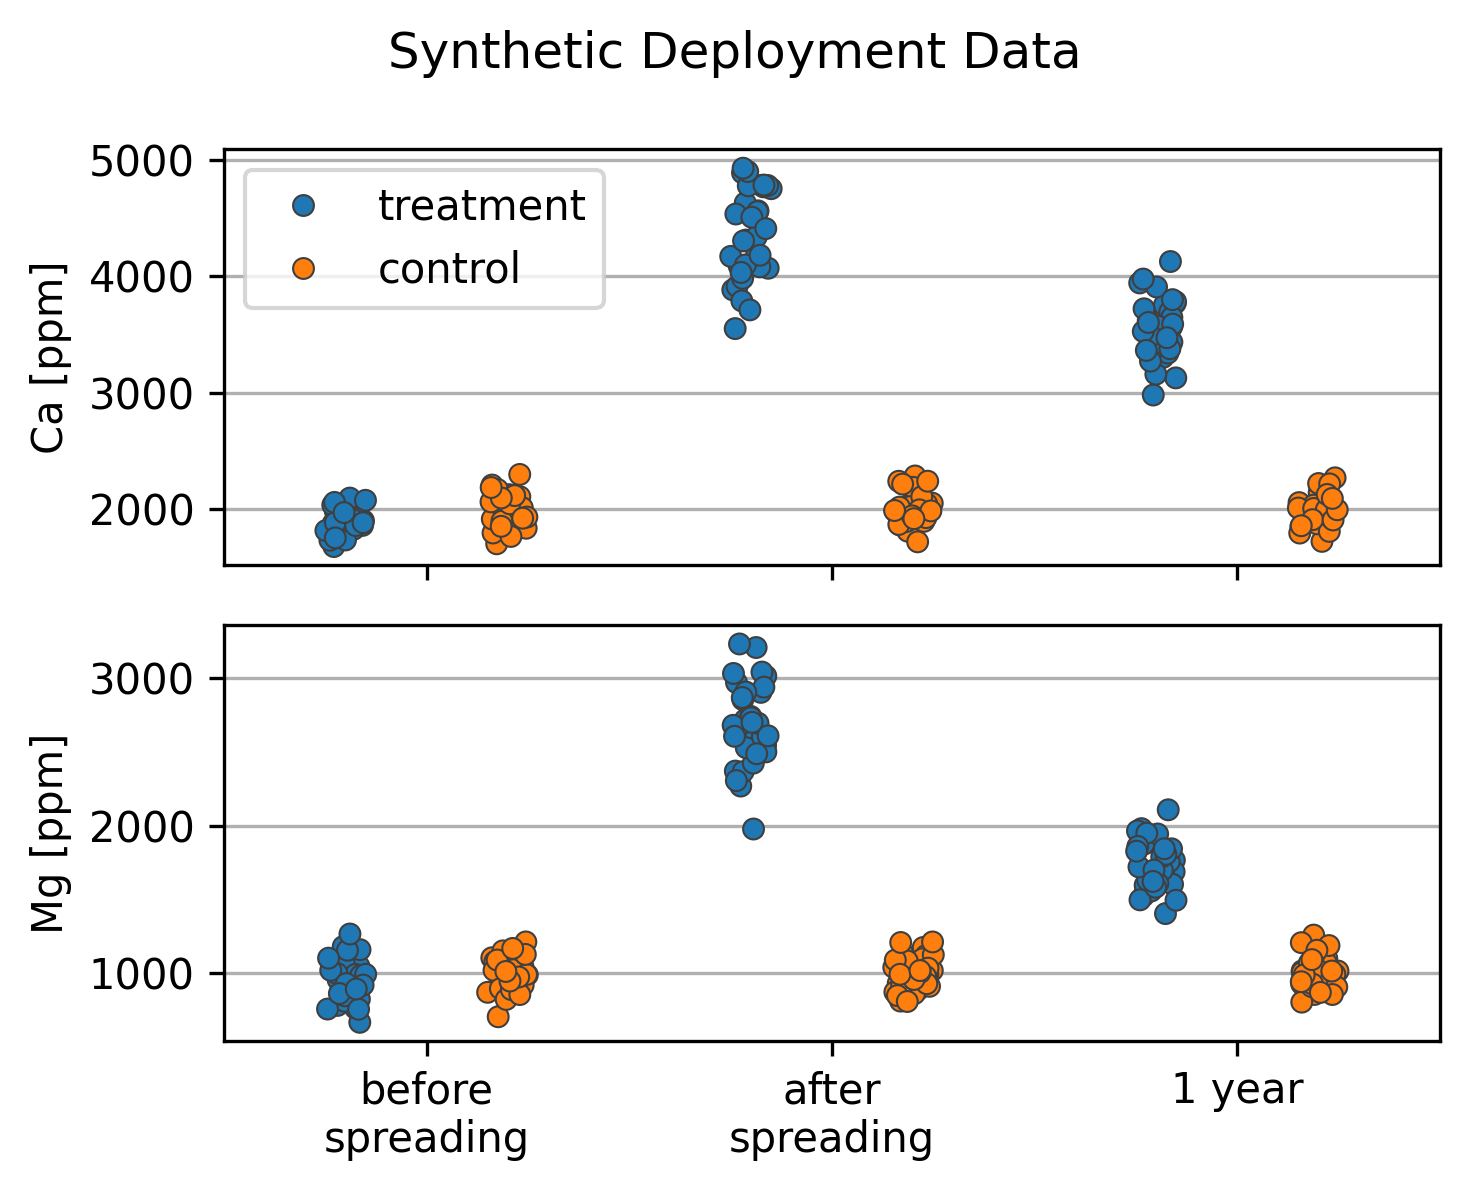

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
sns.stripplot(
    x=data["round"],
    y=data["Ca"] * 1e6,
    hue=data["control"],
    dodge=0.01,
    linewidth=0.5,
    ax=axs[0],
)
axs[0].get_legend().set_title(None)
axs[0].set_ylabel("Ca [ppm]")
sns.stripplot(
    x=data["round"],
    y=data["Mg"] * 1e6,
    hue=data["control"],
    dodge=0.01,
    linewidth=0.5,
    legend=False,
    ax=axs[1],
)
axs[1].set_ylabel("Mg [ppm]")
axs[1].set_xticks([0, 1, 2])
axs[1].set_xlabel(None)
axs[1].set_xticklabels(["before\nspreading", "after\nspreading", "1 year"])
fig.suptitle("Synthetic Deployment Data")
fig.tight_layout()
fig.savefig("plots/stripplot.png")

## fit Bayesian model to simluated dataset

the model is defined in the `demo_module.py` file

In [10]:
# read the realization, automatically arranged for modeling
df = demo_module.load_realization(ds, realization)

In [11]:
# initialize the model
model = demo_module.init_model(demo_module.load_realization(ds, realization))

In [12]:
model

         wet feedstock mass ~ Normal(1.28e+04, 100)
             treatment area ~ Normal(3.2e+03, 32)
               sample depth ~ Gamma(16, f())
feedstock moisture fraction ~ Normal(0.125, 0.025)
    feedstock concentration ~ Normal(<constant>, <constant>)
               soil density ~ Normal(1e+03, 100)
           enrichment sigma ~ Exponential(0.001)
             control change ~ Normal(0, 0.001)
       control change sigma ~ HalfNormal(0, 0.001)
               norm loss mu ~ Uniform(0, 1)
            norm loss sigma ~ Beta(1, 6)
                  norm loss ~ Normal(norm loss mu, norm loss sigma)
            weathered sigma ~ Exponential(0.001)
         dry feedstock mass ~ Deterministic(f(wet feedstock mass, feedstock moisture fraction))
           application rate ~ Deterministic(f(treatment area, wet feedstock mass, feedstock moisture fraction))
                  soil mass ~ Deterministic(f(sample depth, soil density))
            mixing fraction ~ Deterministic(f(treatment area

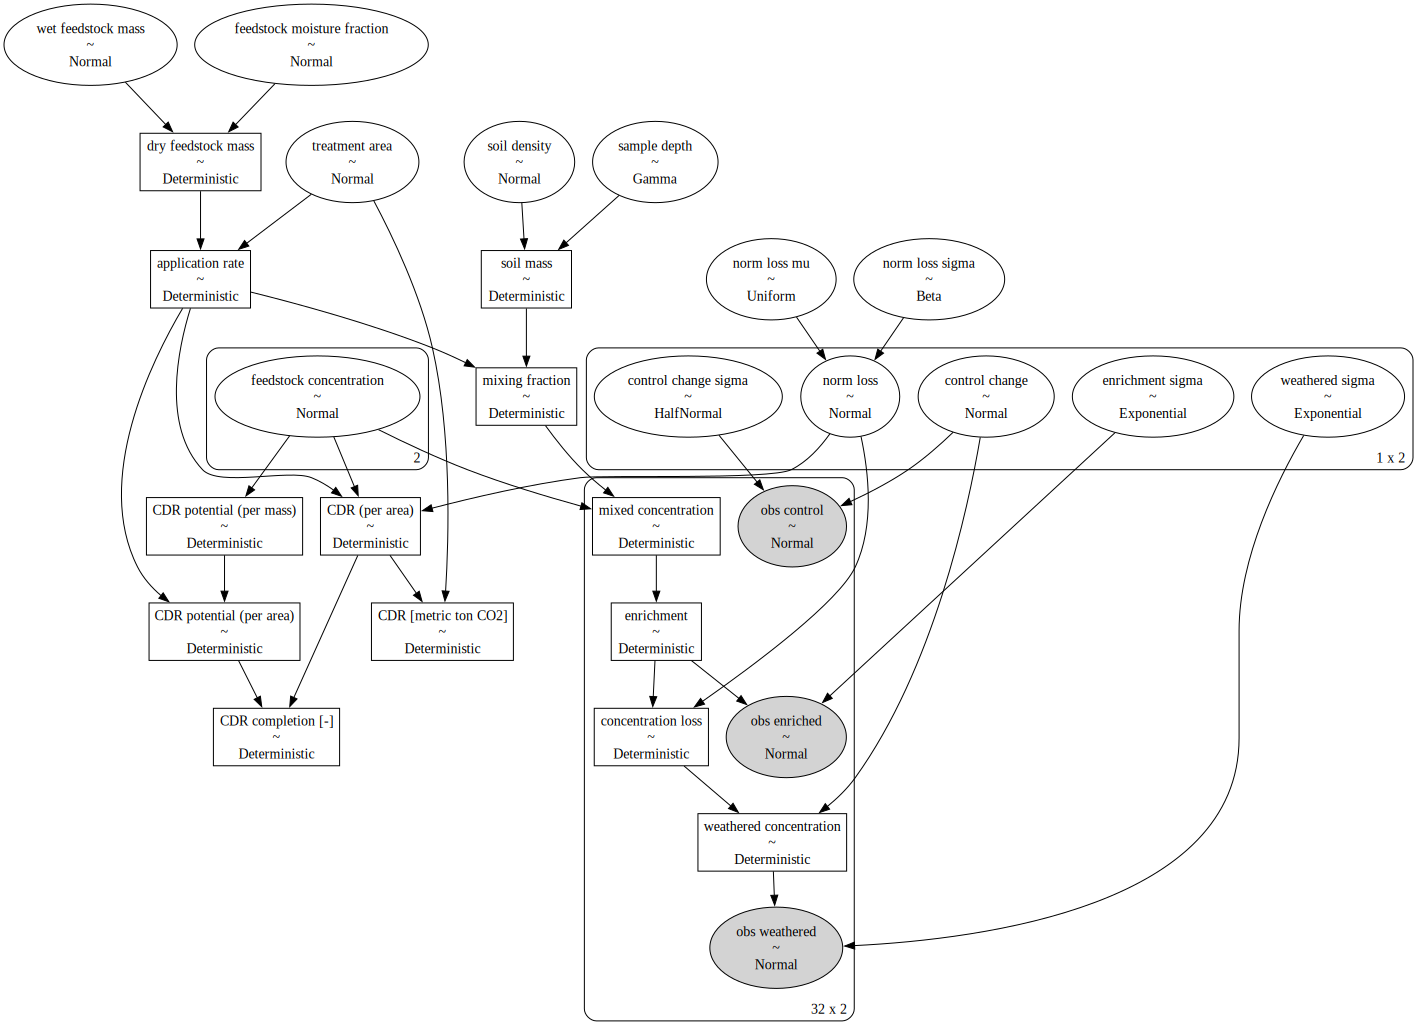

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
    prior = pm.sample_prior_predictive(samples=32_000)
prior.prior.to_netcdf(join("results", "inference", "prior_predictive.nc"))

Sampling: [control change, control change sigma, enrichment sigma, feedstock concentration, feedstock moisture fraction, norm loss, norm loss mu, norm loss sigma, obs control, obs enriched, obs weathered, sample depth, soil density, treatment area, weathered sigma, wet feedstock mass]


In [15]:
with model:
    posterior = pm.sample(
        chains=16, cores=16, tune=4_000, draws=4_000, target_accept=0.95
    )
posterior.posterior.to_netcdf(join("results", "inference", "posterior.nc"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [wet feedstock mass, treatment area, sample depth, feedstock moisture fraction, feedstock concentration, soil density, enrichment sigma, control change, control change sigma, norm loss mu, norm loss sigma, norm loss, weathered sigma]


Sampling 16 chains for 4_000 tune and 4_000 draw iterations (64_000 + 64_000 draws total) took 90 seconds.


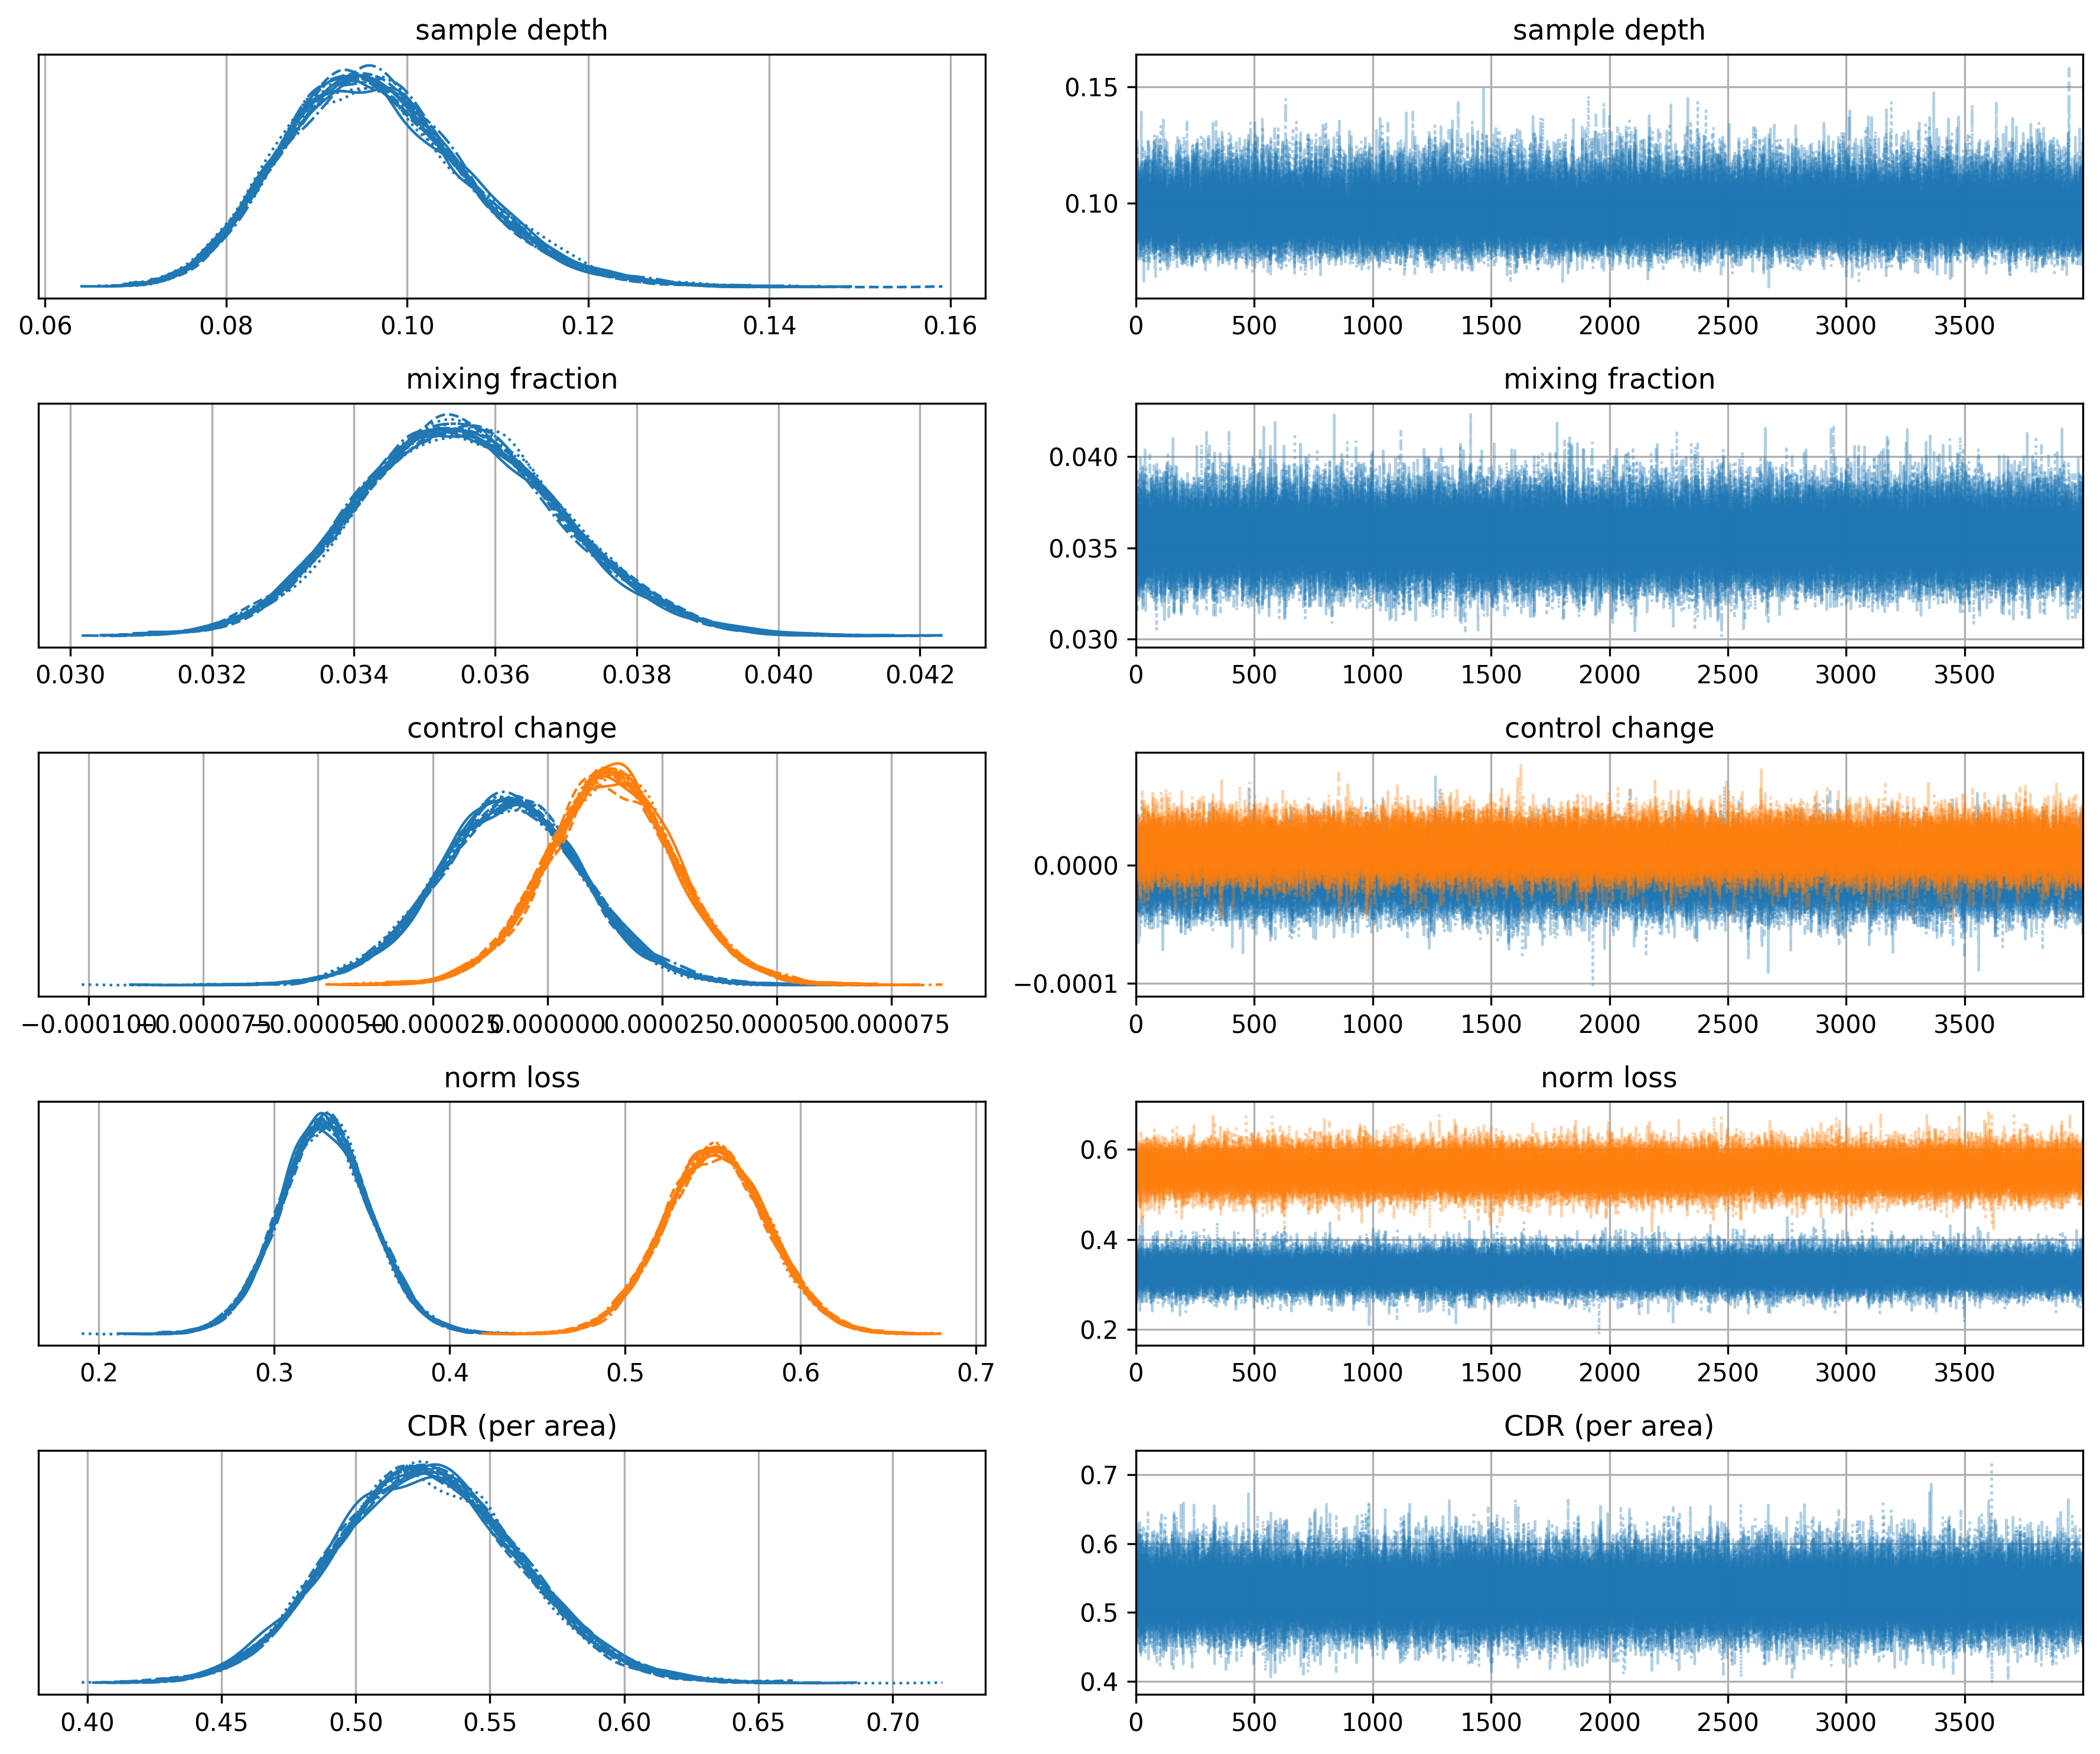

In [16]:
az.plot_trace(
    posterior,
    var_names=[
        "sample depth",
        "mixing fraction",
        "control change",
        "norm loss",
        "CDR (per area)",
    ],
)
plt.gcf().tight_layout()

In [17]:
rhat = az.rhat(posterior)
np.max([rhat[v].max() for v in rhat.data_vars])

1.0006047686414

## compare prior and posterior distributions

In [18]:
az.plot_density(
    [posterior.posterior, prior.prior],
    data_labels=["posterior", "prior"],
    var_names=[
        "wet feedstock mass",
        "treatment area",
        "application rate",
        "sample depth",
        "feedstock moisture fraction",
        "dry feedstock mass",
        "feedstock concentration",
        "soil density",
        "soil mass",
        "mixing fraction",
        "enrichment sigma",
        "weathered sigma",
        "norm loss",
        "control change",
        "CDR potential (per mass)",
        "CDR potential (per area)",
        "CDR (per area)",
        "CDR [metric ton CO2]",
        "CDR completion [-]",
    ],
    hdi_prob=0.995,
)
plt.gcf().tight_layout()

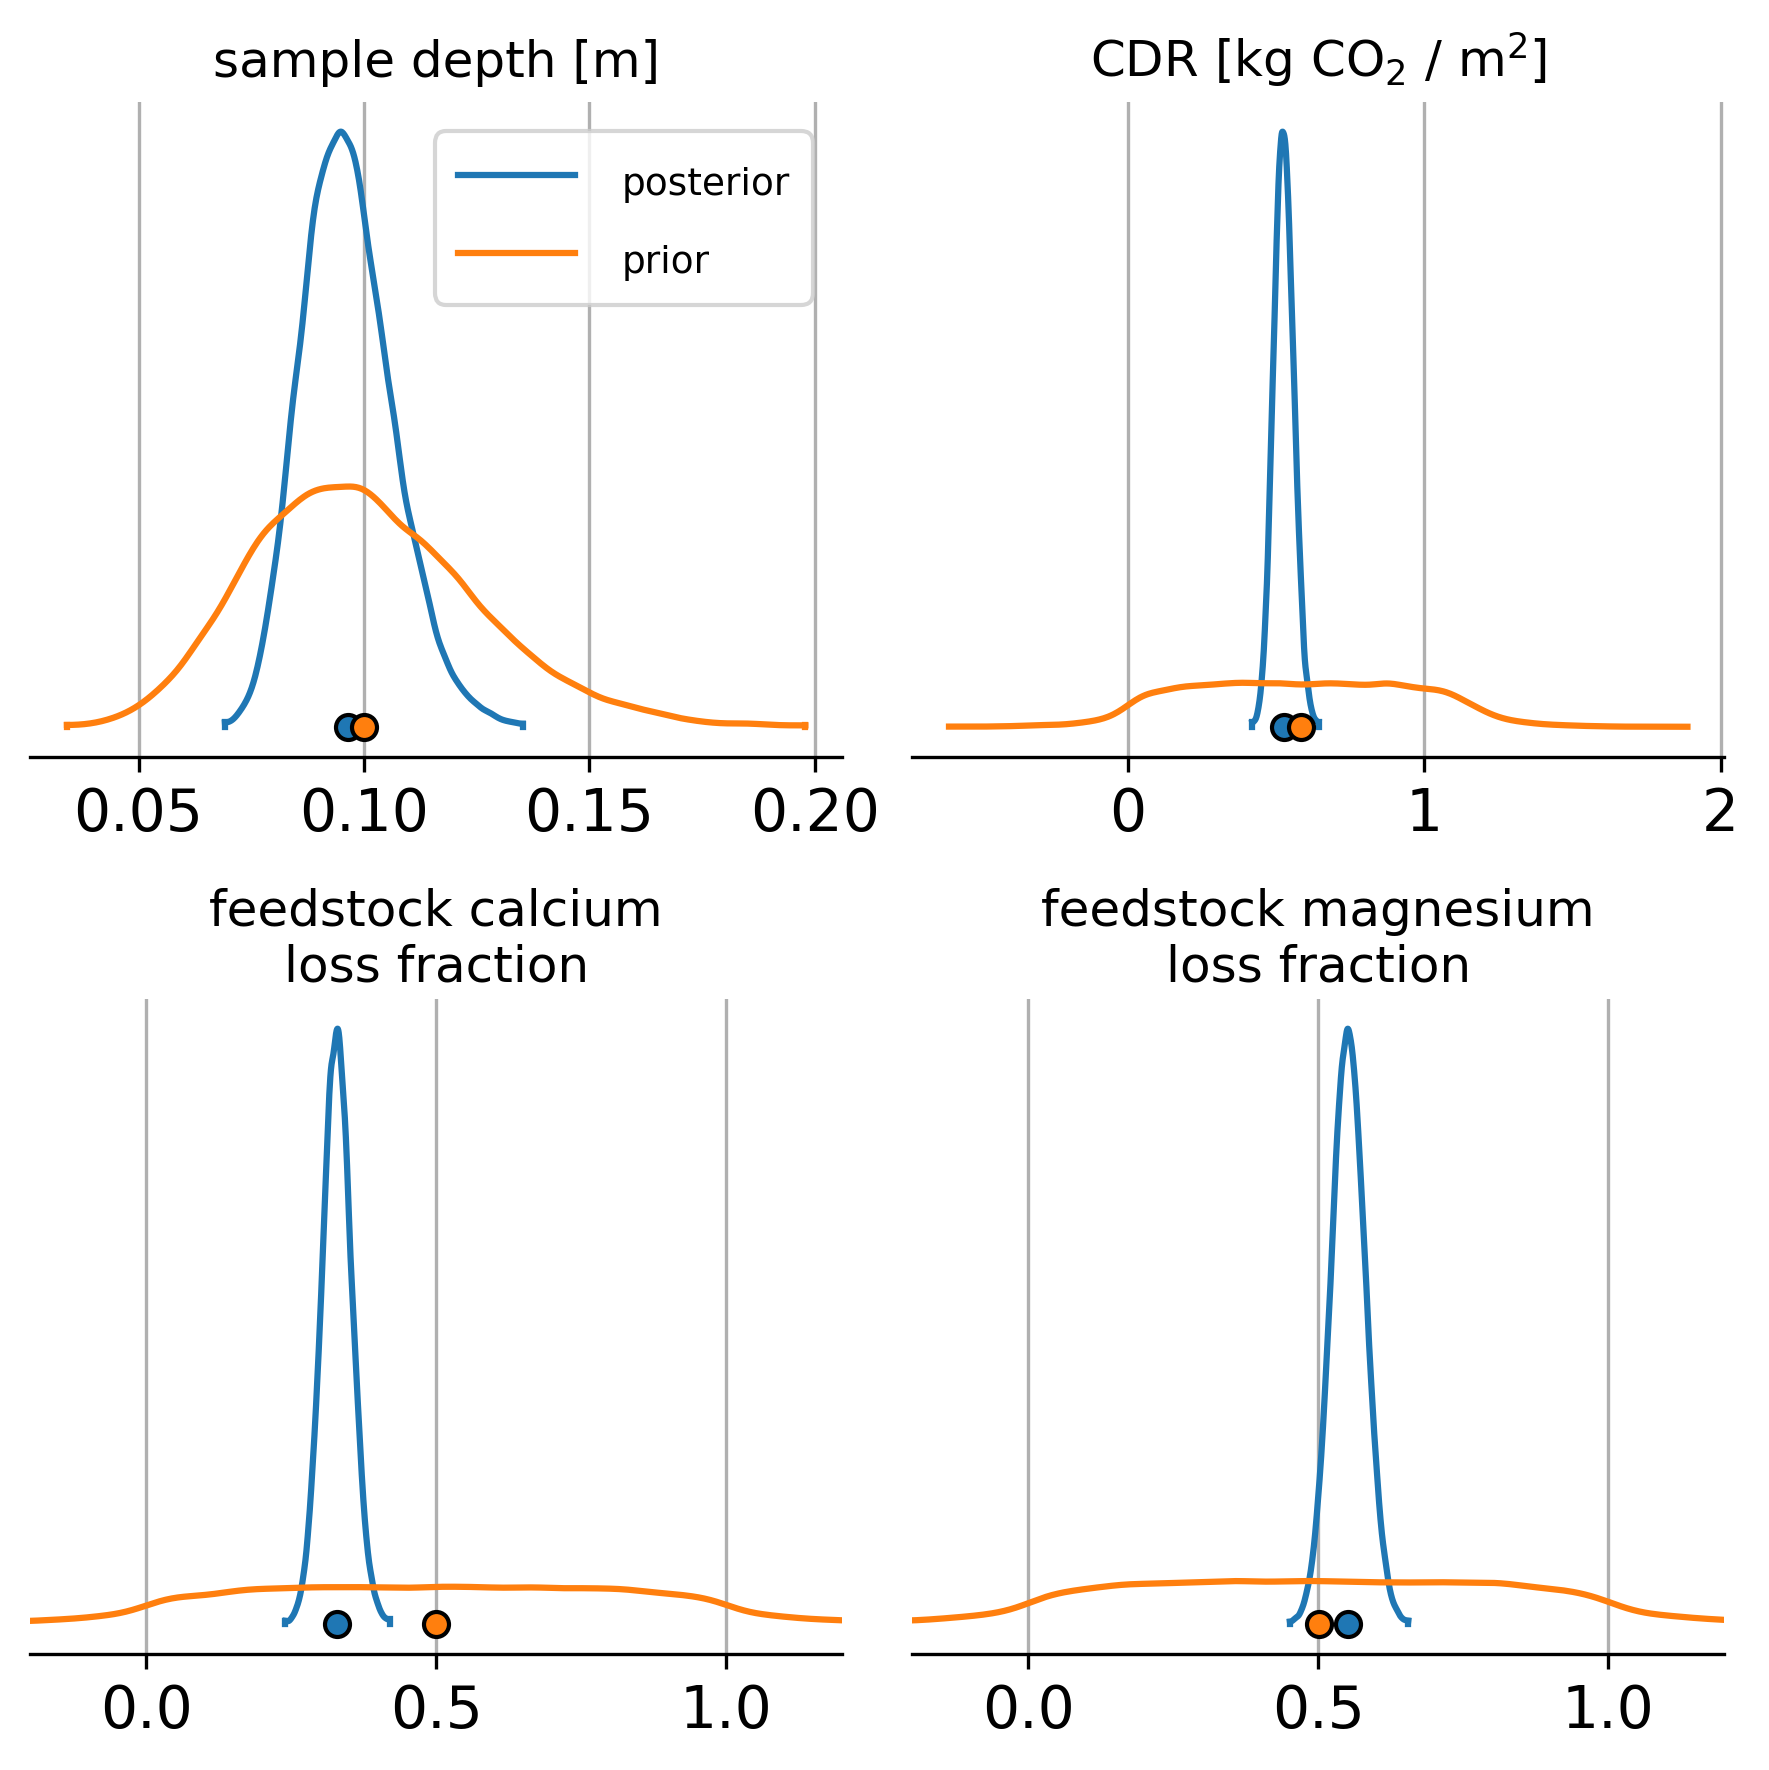

In [19]:
axs = az.plot_density(
    [posterior.posterior, prior.prior],
    data_labels=["posterior", "prior"],
    var_names=["sample depth", "CDR (per area)", "norm loss"],
    hdi_prob=0.999,
    figsize=(6, 6),
    grid=(2, 2),
)
for text in axs[0, 0].get_legend().get_texts():
    text.set_fontsize(9)
axs[0, 0].set_title("sample depth [m]")
axs[0, 1].set_title("CDR [kg CO$_2$ / m$^2$]")
axs[1, 0].set_title("feedstock calcium\nloss fraction")
axs[1, 1].set_title("feedstock magnesium\nloss fraction")
for ax in axs[1, :]:
    ax.set_xlim(-0.2, 1.2)
plt.gcf().tight_layout()
plt.gcf().savefig("plots/prior_posterior.png")

In [20]:
posterior.posterior["norm loss"].mean(dim=("chain", "draw"))

<xarray.DataArray 'norm loss' (norm loss_dim_0: 1, norm loss_dim_1: 2)> Size: 16B
array([[0.3290347 , 0.55187472]])
Coordinates:
  * norm loss_dim_0  (norm loss_dim_0) int64 8B 0
  * norm loss_dim_1  (norm loss_dim_1) int64 16B 0 1

## postierior predictive check

In [21]:
with model:
    ppc = pm.sample_posterior_predictive(posterior)

Sampling: [obs control, obs enriched, obs weathered]


array([<Axes: xlabel='obs enriched'>, <Axes: xlabel='obs control'>,
       <Axes: xlabel='obs weathered'>], dtype=object)

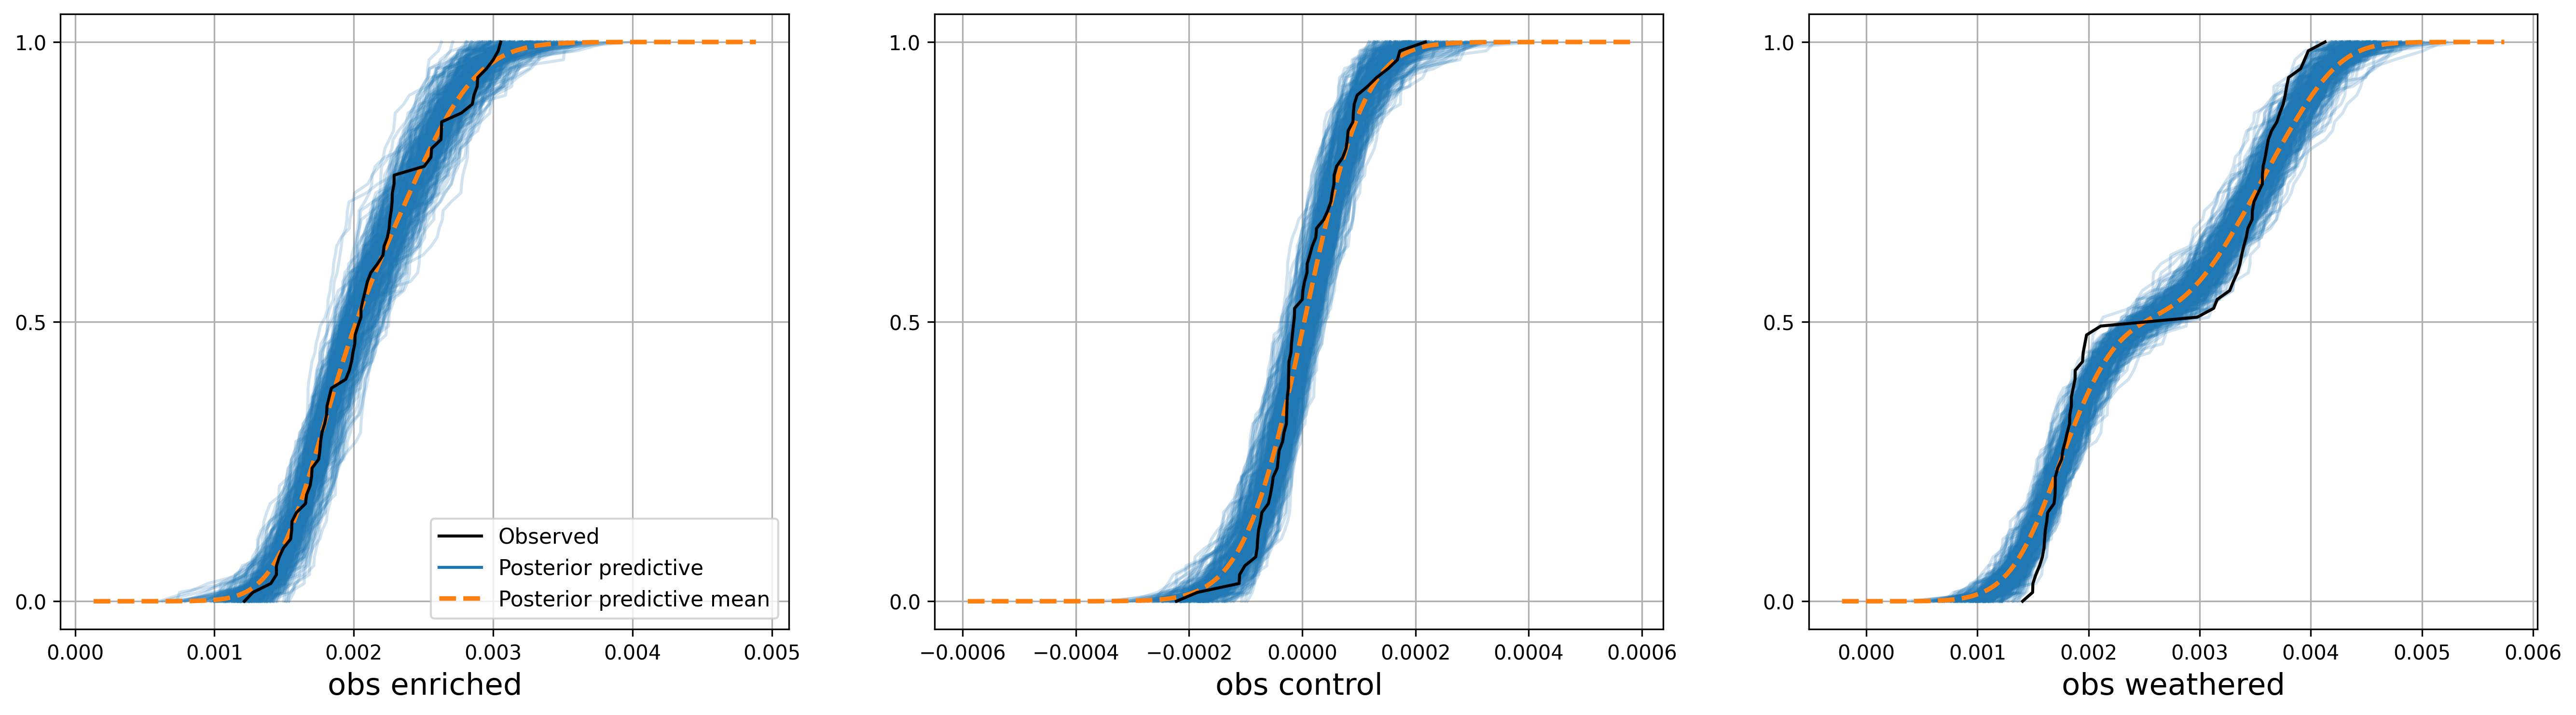

In [22]:
az.plot_ppc(ppc, num_pp_samples=250, kind="cumulative")

## inspect Weathering & CDR posteriors

In [23]:
loss = np.array([1 - np.exp(-0.4), 1 - np.exp(-0.8)])
print(f"{100*loss[0]:g} % Ca loss, {100*loss[1]:g} Mg loss")
cdrperarea = np.sum(loss * 3.5 * np.array([0.07, 0.05]) * np.array([2.196, 3.621]))
print(f"{cdrperarea:g} kg CDR / m^2")
total = (3200 / 1e3) * cdrperarea
print(f"{total:g} tons CDR")
completion = total / (
    (3200 / 1e3) * np.sum(3.5 * np.array([0.07, 0.05]) * np.array([2.196, 3.621]))
)
print(f"{100 * completion:g} % CDR completion")

32.968 % Ca loss, 55.0671 Mg loss
0.526321 kg CDR / m^2
1.68423 tons CDR
44.9196 % CDR completion


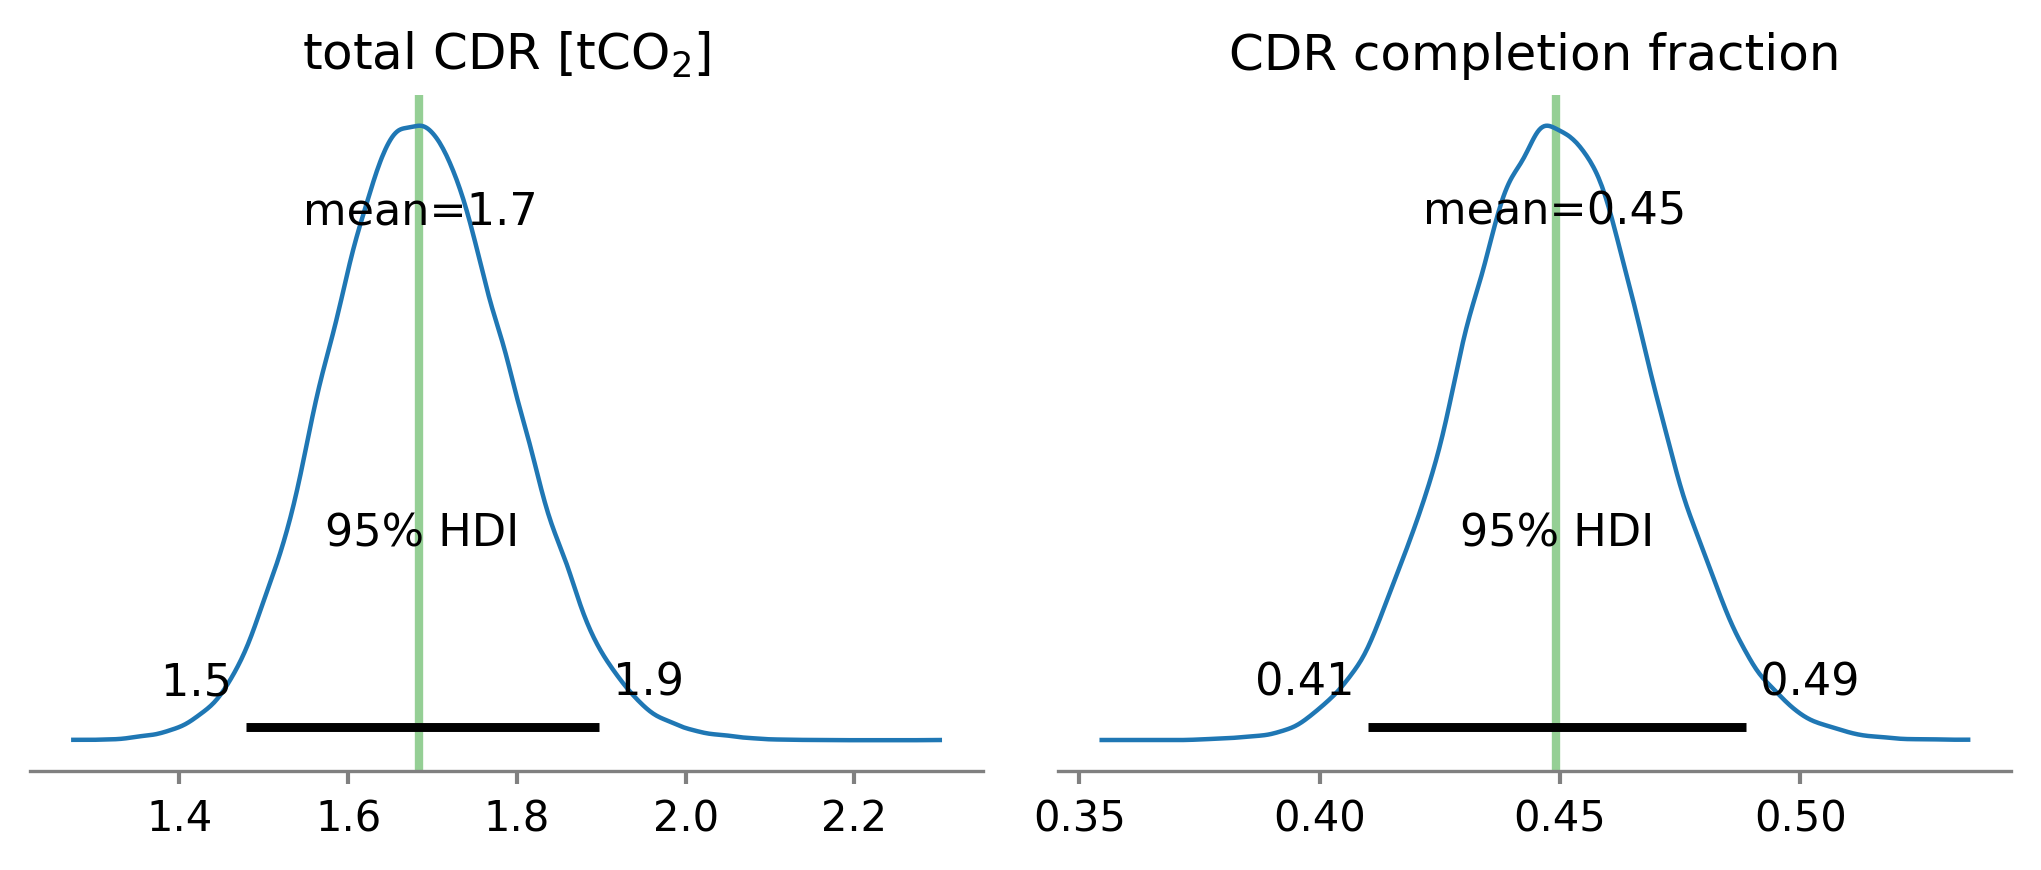

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
az.plot_posterior(
    posterior,
    var_names=[
        "CDR [metric ton CO2]",
        "CDR completion [-]",
    ],
    hdi_prob=0.95,
    textsize=10,
    ax=axs,
)
axs[0].axvline(
    total,
    color="C2",
    alpha=0.5,
    linewidth=2,
    zorder=0,
)
axs[0].set_title("total CDR [tCO$_2$]", fontsize=12)
axs[1].axvline(
    completion,
    color="C2",
    alpha=0.5,
    linewidth=2,
    zorder=0,
)
axs[1].set_title("CDR completion fraction", fontsize=12)
for ax in axs.flatten():
    ax.grid(False)
fig.tight_layout()
fig.savefig("plots/posteriors.png")